In [1]:
import sys
import os
import system_config as sc

system_configuration = sc.get_system_config()
sys.path.insert(0, system_configuration['code_tensorlfow'])

import input_data
import models

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train_logdir = system_configuration['train_log_tensorflow']
graph_path = os.path.join(train_logdir, 'my_frozen_graph.pb')
label_path = os.path.join(train_logdir, 'speech_commands_train','conv_labels.txt')

In [14]:
## all the arguments of tensorflow's tutorial.
## files management.
data_url      = 0
data_dir      = system_configuration['data_tensorflow']
summaries_dir = os.path.join(system_configuration['train_log_debug'],'retrain_log'  )
wanted_words  ='yes,no,up,down,left,right,on,off,stop,go'
train_dir     = os.path.join(system_configuration['train_log_debug'], 'speech_commands_train')
start_checkpoint=''
check_nans=False
# help='Whether to check for invalid numbers during processing')

## training management
background_volume = 0.1
background_frequency=0.8
silence_percentage=10.0
unknown_percentage=10.0
testing_percentage=10
validation_percentage=10
time_shift_ms =100.0
how_many_training_steps=['15000,3000']
eval_step_interval=400
# help='How often to evaluate the training results.')
batch_size=100
save_step_interval=100

## model management
model_architecture='conv'
learning_rate=['0.001,0.0001']

## parameter management

## audio processing management.
sample_rate = 16000
clip_duration_ms = 1000
window_size_ms = 30.0
# help='How long each spectrogram timeslice is',)
window_stride_ms = 10.0
# help='How long each spectrogram timeslice is',)
dct_coefficient_count = 40

## our parameter
# clean up the data a little bit
pct_thresh = [5, 99]


In [15]:
# load model 
model_settings = models.prepare_model_settings(
  len(input_data.prepare_words_list(wanted_words.split(','))),
  sample_rate, clip_duration_ms, window_size_ms,
  window_stride_ms, dct_coefficient_count)

In [92]:
from importlib import reload
reload(input_data)
# create audio_processor
audio_processor = input_data.AudioProcessor(
  data_url, data_dir, silence_percentage,
  unknown_percentage,
  wanted_words.split(','), validation_percentage,
  testing_percentage, model_settings)
fingerprint_size = model_settings['fingerprint_size']
label_count = model_settings['label_count']
time_shift_samples = int((time_shift_ms * sample_rate) / 1000)



In [109]:
# get some data
batch_size = 16
with tf.Session() as sess:
    train_fingerprints, train_ground_truth = audio_processor.get_data(
        batch_size, 0, model_settings, background_frequency,
        background_volume, time_shift_samples, 'validation', sess)

input_frequency_size = model_settings['dct_coefficient_count']
input_time_size = model_settings['spectrogram_length']
fingerprint_3d = np.reshape(train_fingerprints,
                          [-1, input_time_size, input_frequency_size, 1])

In [110]:
train_ground_truth

array([  5.,   7.,   5.,  10.,  10.,   0.,   9.,   2.,   2.,  10.,   6.,
        10.,  11.,   8.,   3.,   4.])

In [85]:
import copy as cp
fingerprint_list = [None for ii in range(batch_size)]
for ii in range(batch_size):
    fingerprint_list[ii] = cp.copy(fingerprint_3d[ii,:,:,0])

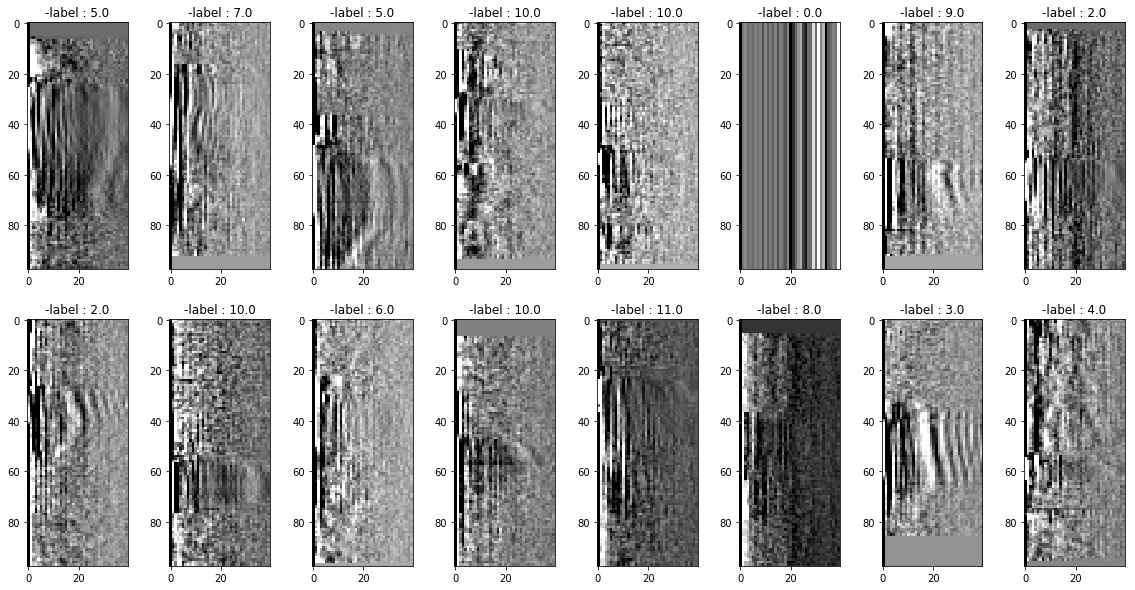

In [113]:
%matplotlib inline

fig = plt.figure(figsize = (20, 10))
for ii in range(fingerprint_3d.shape[0]):
    ax = plt.subplot(2, 8, ii + 1)
    imgplot = ax.imshow(fingerprint_list[ii], cmap ='gray')
    ax.set_title('-label : '+ str(train_ground_truth[ii]))

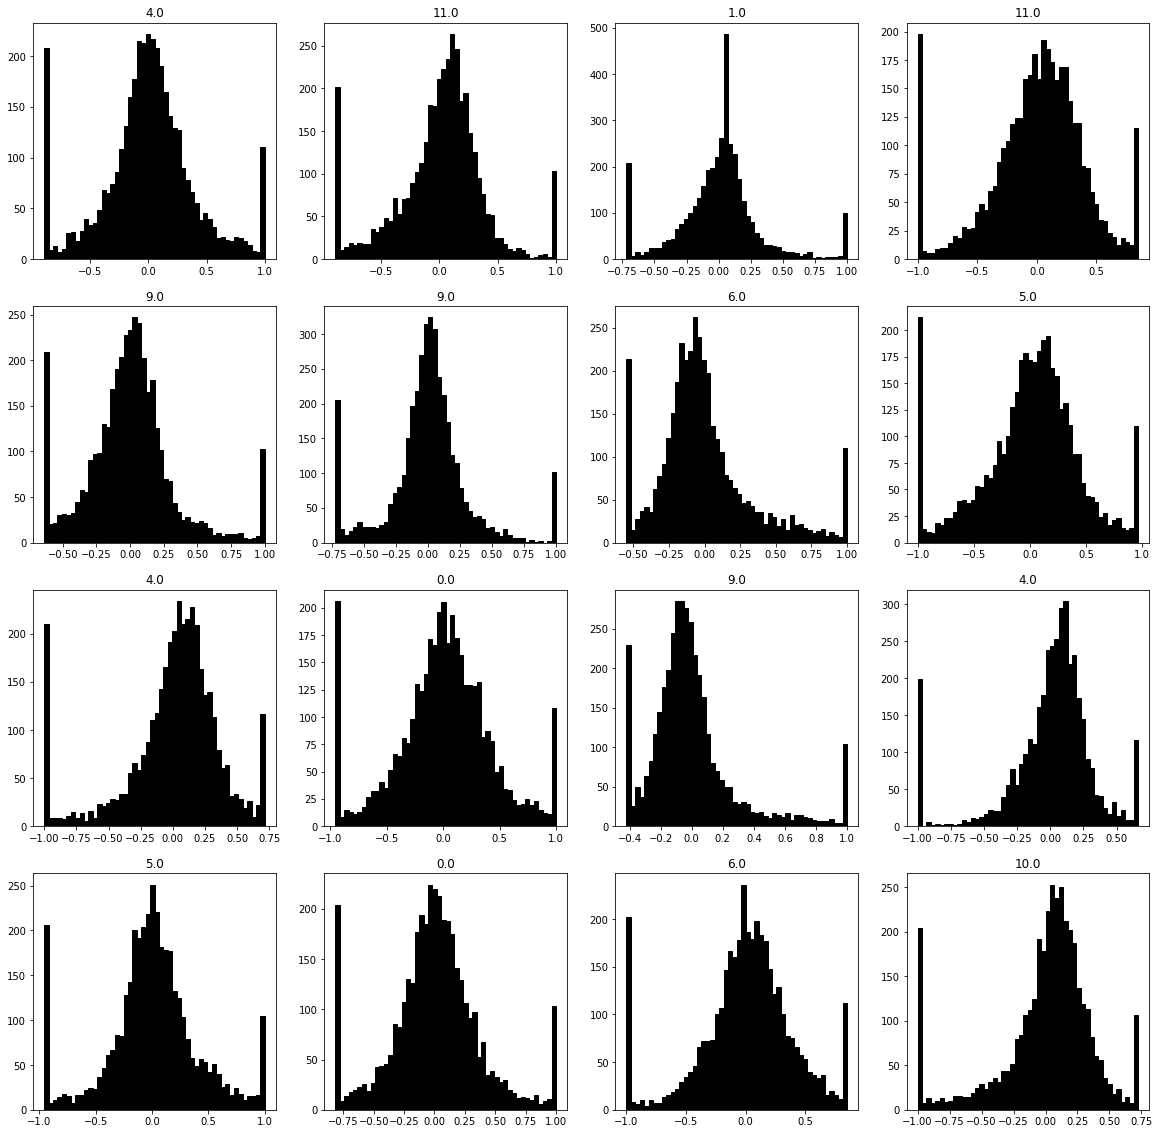

In [72]:
fig = plt.figure(figsize = (20, 20))
for ii in range(batch_size):
    ax = plt.subplot(4,4, ii + 1)
    ax.hist(fingerprint_list[ii].ravel(), bins = 50, fc = 'k', ec = 'k')
    ax.set_title(str(train_ground_truth[ii]))

In [97]:
# check whether the label is correct. should be!!
batch_size = 16
with tf.Session() as sess:
    raw_audio_data, raw_audio_label = audio_processor.get_unprocessed_data(
        batch_size, model_settings, 'validation')


In [98]:
raw_audio_label

['down',
 'right',
 'down',
 'stop',
 'stop',
 '_silence_',
 'off',
 'yes',
 'yes',
 'stop',
 'left',
 'stop',
 'go',
 'on',
 'no',
 'up']

In [100]:
import IPython.display as ipd
audio_this = raw_audio_data[9]
ipd.Audio(audio_this, rate = sample_rate)